# Bioproduct separation

The separation and purification of bioproducts from fermentation broths often require a combination of liquid-liquid exatraction (large, non-polar molecules), distillation (small, polar molecules), and adsorption (dilute non-polar products). In this case study, we will build a typical separation process for acetic acid and review BioSTEAM's capabilities for extraction and distillation. 

### Thermodynamic considerations

Before creating the process, it can be useful to study the physical phenomena being used in the separation. Let's first plot the phase envelope of acetic acid and water to see if distillation is possible:

In [1]:
import biosteam as bst
bst.nbtutorial() # For light-mode diagrams, ignore warnings

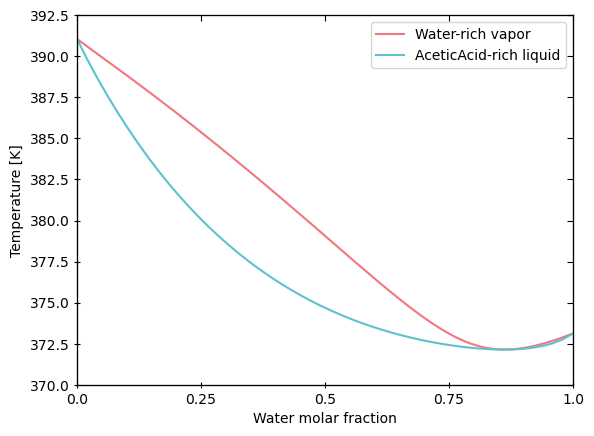

In [2]:
bst.plot_vle_binary_phase_envelope(['Water', 'AceticAcid'], P=101325)

Water and acetic acid have an azeotrope, so volatility based separation cannot completely separate acetic acid. Now let's check whether a solvent such as ethyl acetate can be used for liquid-liquid extraction:

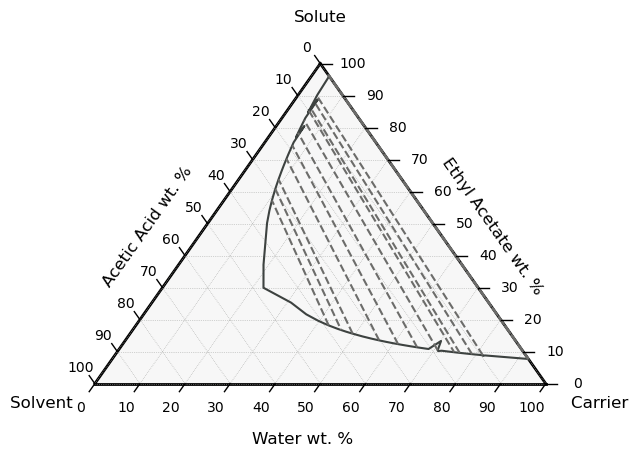

In [3]:
bst.plot_lle_ternary_diagram(
    carrier='Water', solvent='EthylAcetate', solute='AceticAcid', T=298.15, P=101325,
    method='shgo'
)

Ethyl acetate is a good solvent. Now let's confirm that we can separate acetic acid from the solvent more easily:

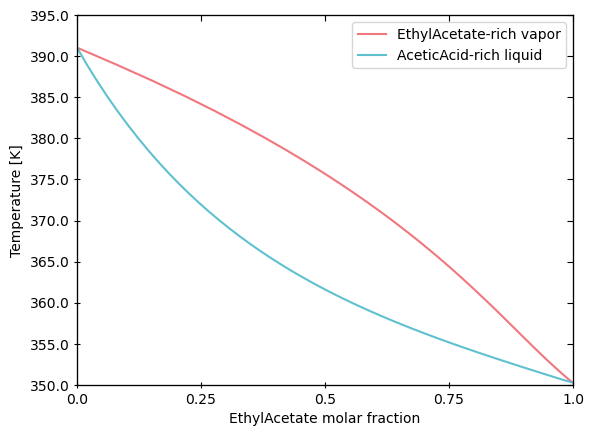

In [4]:
bst.plot_vle_binary_phase_envelope(['EthylAcetate', 'AceticAcid'], P=101325)

Confirmed, a liquid-liquid extraction separation process is feasible. Let's check the volatility of the components to understand which should be the distillate and bottoms products:

In [5]:
for i in bst.Chemicals(['Water', 'EthylAcetate', 'AceticAcid']): print(i, round(i.Tb, 2), 'K')

Water 373.12 K
EthylAcetate 350.25 K
AceticAcid 391.05 K


## Glacial acetic acid production

Ethyl acetate will need to be recoved from the raffinate as the more volatile component (light key). Acetic acid can be recoved from the extact as a the heavy key. Based on this knowledge, we can construct the following flowsheet (adapted from Seader's Separation Process Principles, 3rd Edition) glacial acetic acid production from dilute acetic acid:

![GAA](../images/GAA.png)

### Preliminary design

Let's start by creating a preliminary system using shortcut columns for speed and flexibility:

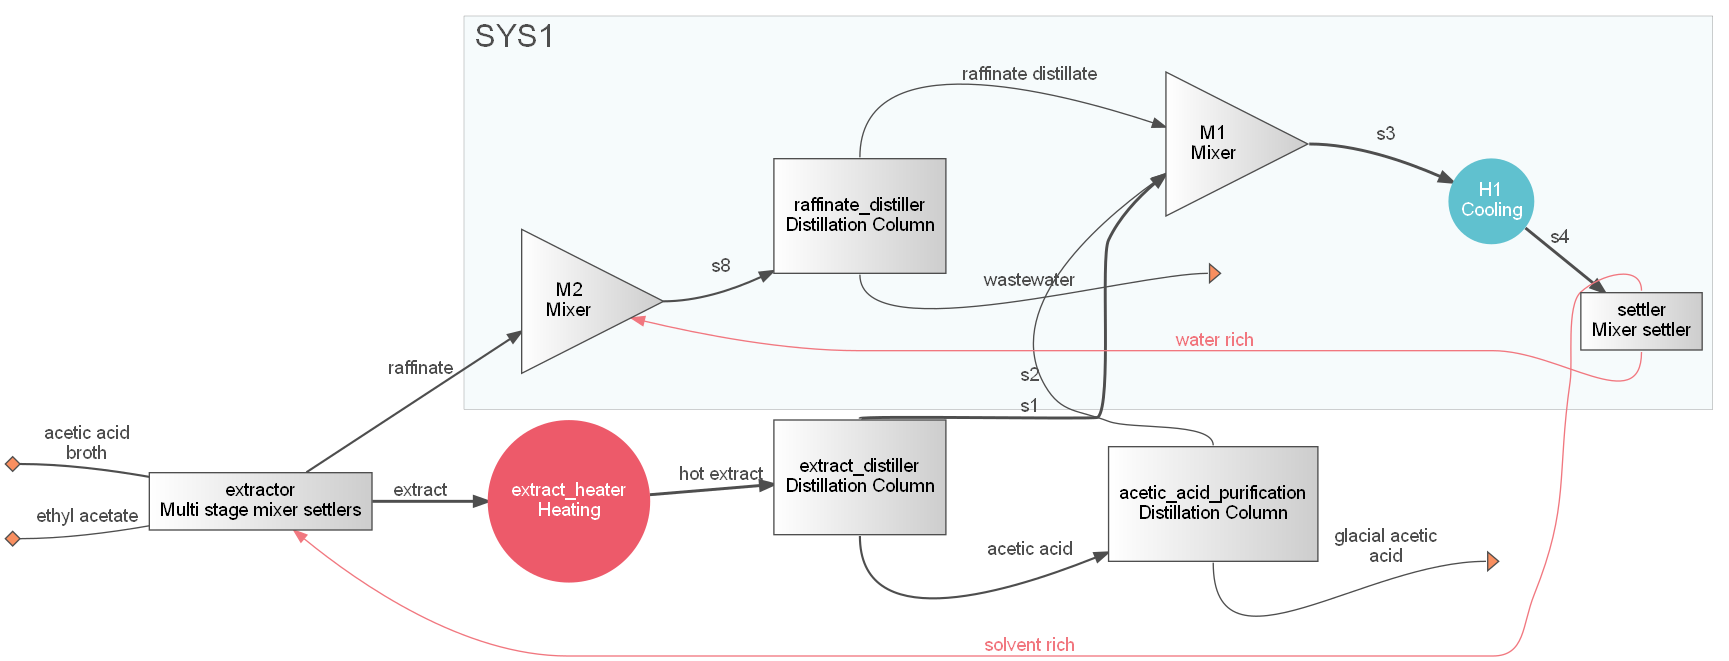

System: AAsep
Highest convergence error among components in recycle
stream settler-0 after 3 loops:
- flow rate   1.17e-02 kmol/hr (0.14%)
- temperature 0.00e+00 K (0%)
ins...
[0] acetic_acid_broth  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water       500
                    AceticAcid  16.7
[1] ethyl_acetate  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): EthylAcetate  0.111
outs...
[0] wastewater  
    phase: 'l', T: 372.4 K, P: 101325 Pa
    flow (kmol/hr): Water         500
                    AceticAcid    2.11
                    EthylAcetate  0.0843
[1] glacial_acetic_acid  
    phase: 'l', T: 390.74 K, P: 101325 Pa
    flow (kmol/hr): Water         0.000133
                    AceticAcid    14.5
                    EthylAcetate  0.0385


In [6]:
# Define chemicals used in the process
bst.settings.set_thermo(['Water', 'AceticAcid', 'EthylAcetate'])

# Amount of ethyl-acetate to fermentation broth
solvent_feed_ratio = 1.5

# Fermentation broth with dilute acetic acid
acetic_acid_broth = bst.Stream(ID='acetic_acid_broth', AceticAcid=1000, Water=9000, units='kg/hr')

# Solvent 
ethyl_acetate = bst.Stream(ID='ethyl_acetate',  EthylAcetate=1)

# Products
glacial_acetic_acid = bst.Stream(ID='glacial_acetic_acid')
wastewater = bst.Stream(ID='wastewater')

# Recycles
solvent_recycle = bst.Stream('solvent_rich')
water_rich = bst.Stream('water_rich')
distillate = bst.Stream('raffinate_distillate')

# System and unit operations
with bst.System('AAsep') as sys:
    extractor = bst.MultiStageMixerSettlers(
        'extractor', 
        ins=(acetic_acid_broth, ethyl_acetate, solvent_recycle), 
        outs=('extract', 'raffinate'),
        top_chemical='EthylAcetate',
        feed_stages=(0, -1, -1),
        N_stages=12,
        use_cache=True,
    )

    @extractor.add_specification(run=True)
    def adjust_fresh_solvent_flow_rate():
        broth = acetic_acid_broth.F_mass
        EtAc_recycle = solvent_recycle.imass['EthylAcetate']
        other_recycle = solvent_recycle.F_mass - EtAc_recycle
        ethyl_acetate.imass['EthylAcetate'] = max(
            0, (broth + other_recycle) * solvent_feed_ratio - EtAc_recycle
        )

    HX = bst.HXutility(
        'extract_heater',
        ins=(extractor.extract),
        outs=('hot_extract'),
        rigorous=True,
        V=0,
    )
    ED = bst.ShortcutColumn(
        'extract_distiller',
        ins=HX-0,
        outs=['', 'acetic_acid'],
        LHK=('Water', 'AceticAcid'),
        Lr=0.95,
        Hr=0.95,
        k=1.4,
        partial_condenser=False,
    )
    ED2 = bst.ShortcutColumn(
        'acetic_acid_purification',
        ins=ED-1,
        outs=('', glacial_acetic_acid),
        LHK=('EthylAcetate', 'AceticAcid'),
        Lr=0.999,
        Hr=0.999,
        k=1.4,
        partial_condenser=False
    )
    ED.check_LHK = ED2.check_LHK = False
    mixer = bst.Mixer(
        ins=(ED-0, ED2-0, distillate)
    )
    HX = bst.HXutility(ins=mixer-0, T=310)
    settler = bst.MixerSettler(
        'settler',
        ins=HX-0, 
        outs=(solvent_recycle, water_rich),
        top_chemical='EthylAcetate',
    )
    mixer = bst.Mixer(ins=[extractor.raffinate, water_rich])
    RD = bst.ShortcutColumn(
        'raffinate_distiller',
        LHK=('EthylAcetate', 'Water'),
        ins=mixer-0,
        outs=[distillate, wastewater],
        partial_condenser=False,
        Lr=0.99,
        Hr=0.99,
        k=1.5,
    )
    
sys.simulate()
sys.diagram(kind='cluster', format='png')
sys.show()

In [7]:
sys.operating_hours = 330 * 24
print('CAPEX', round(sys.installed_equipment_cost / 1e6, 3), 'MMUSD')
print('OPEX', round(sys.material_cost + sys.utility_cost / 1e6, 4), 'MMUSD/yr')

CAPEX 1.754 MMUSD
OPEX 0.9323 MMUSD/yr


### Rigorous design

To model side draws and feeds at multiple stages, we will need to use rigorous MESH-based (Mass, Equilibrium, Summation, and entHalpy) distillation models. We can look at the design results for the ShortcutColumn to get heuristic design specifications for the rigorous column:

In [8]:
print(ED.results())
outlet = ED.reboiler.outs[0]
boilup = outlet['g'].F_mol / outlet['l'].F_mol
distillate, condensate = ED.top_split.outs
split = condensate.F_mol / ED.condenser.outs[0].F_mol # Or from ED.design_results['Reflux']
N_stages = int(ED.design_results['Theoretical stages'])
feed_stage = int(ED.design_results['Theoretical feed stage'])

Distillation Column                              Units  extract_distiller
Electricity         Power                           kW               1.71
                    Cost                        USD/hr              0.134
Cooling water       Duty                         kJ/hr          -8.35e+06
                    Flow                       kmol/hr            5.7e+03
                    Cost                        USD/hr               2.78
Low pressure steam  Duty                         kJ/hr           8.81e+06
                    Flow                       kmol/hr                228
                    Cost                        USD/hr               54.1
Design              Theoretical feed stage                              7
                    Theoretical stages                                  9
                    Minimum reflux               Ratio              0.269
                    Reflux                       Ratio              0.377
                    Actual stages     

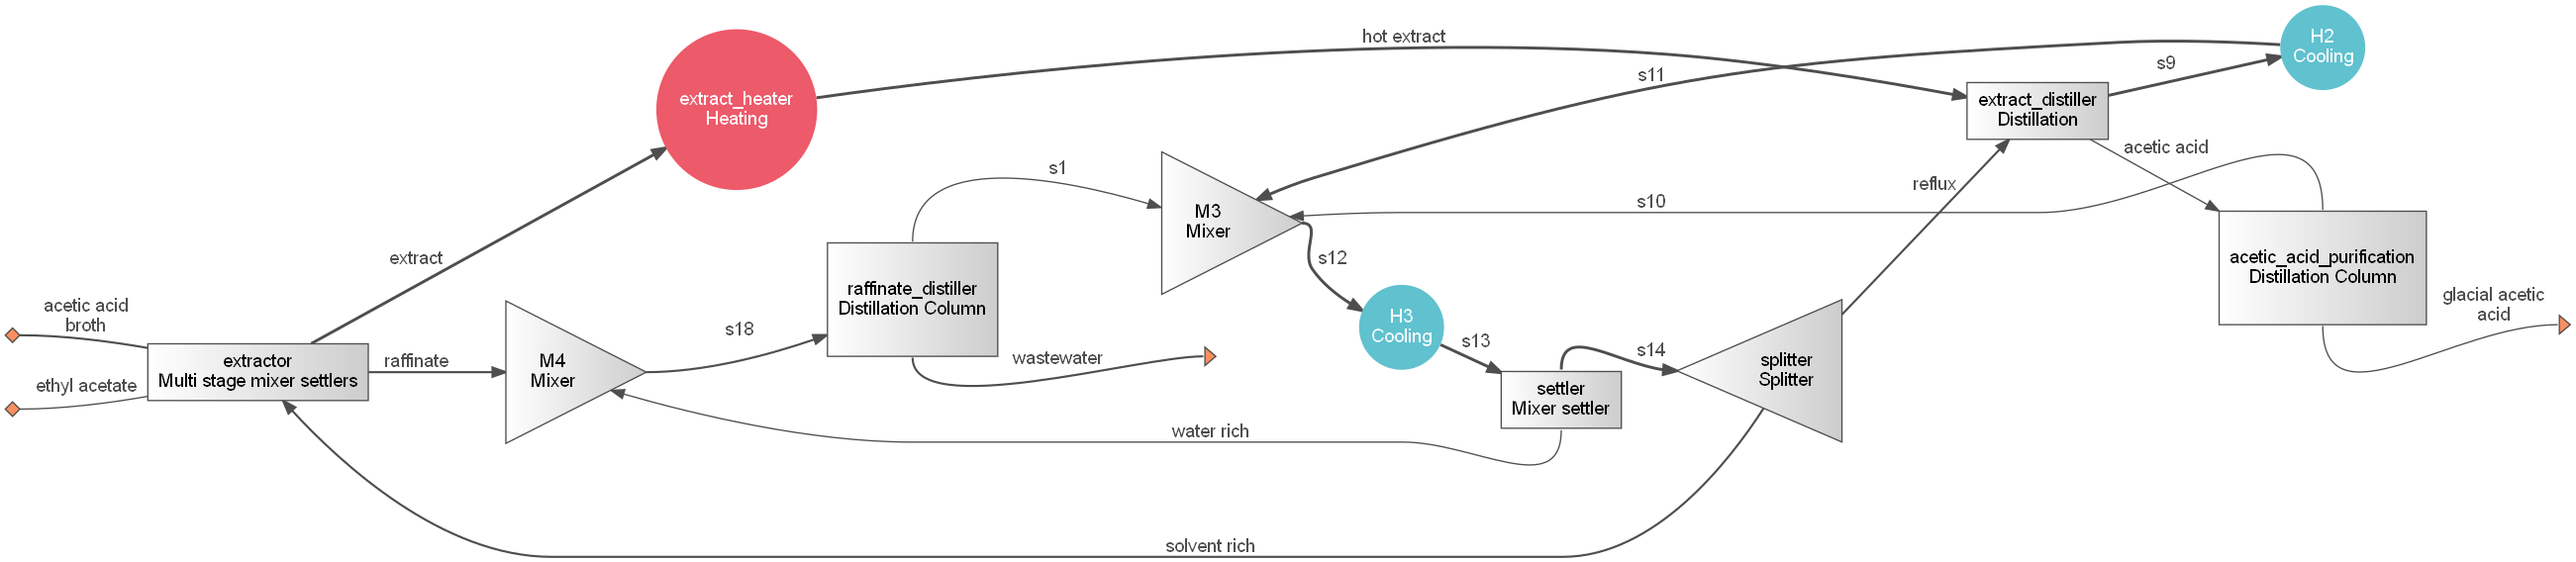

System: AAsep
Highest convergence error among components in recycle
streams {extract_heater-0, splitter-1, M3-0, settler-1} after 22 loops:
- flow rate   8.72e-05 kmol/hr (0.00025%)
- temperature 1.52e-06 K (4.4e-07%)
ins...
[0] acetic_acid_broth  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water       500
                    AceticAcid  16.7
[1] ethyl_acetate  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): EthylAcetate  0.14
outs...
[0] wastewater  
    phase: 'l', T: 372.4 K, P: 101325 Pa
    flow (kmol/hr): Water         500
                    AceticAcid    1.92
                    EthylAcetate  0.0841
[1] glacial_acetic_acid  
    phase: 'l', T: 390.62 K, P: 101325 Pa
    flow (kmol/hr): Water         9.96e-05
                    AceticAcid    14.7
                    EthylAcetate  0.0555


In [9]:
reflux = bst.Stream('reflux')

# Amount of ethyl-acetate to fermentation broth
solvent_feed_ratio = 1.5

# System and unit operations
with bst.System('AAsep') as sys:
    extractor = bst.MultiStageMixerSettlers(
        'extractor', 
        ins=(acetic_acid_broth, ethyl_acetate, solvent_recycle), 
        outs=('extract', 'raffinate'),
        top_chemical='EthylAcetate',
        feed_stages=(0, -1, -1),
        N_stages=12, 
        use_cache=True,
    )

    @extractor.add_specification(run=True)
    def adjust_fresh_solvent_flow_rate():
        broth = acetic_acid_broth.F_mass
        EtAc_recycle = solvent_recycle.imass['EthylAcetate']
        other_recycle = solvent_recycle.F_mass - EtAc_recycle
        ethyl_acetate.imass['EthylAcetate'] = max(
            0, (broth + other_recycle) * solvent_feed_ratio - EtAc_recycle
        )

    HX = bst.HXutility(
        'extract_heater',
        ins=(extractor.extract),
        outs=('hot_extract'),
        rigorous=True,
        V=0,
    )
    ED = bst.MESHDistillation(
        'extract_distiller',
        ins=(HX-0, reflux),
        outs=('', 'acetic_acid'),
        feed_stages=[feed_stage-3, 1], 
        N_stages=N_stages,
        reflux=0,
        boilup=boilup,
        LHK=('Water', 'AceticAcid'),
    )
    ED2 = bst.ShortcutColumn(
        'acetic_acid_purification',
        ins=ED-1,
        outs=('', glacial_acetic_acid),
        LHK=('EthylAcetate', 'AceticAcid'),
        Lr=0.999,
        Hr=0.999,
        k=1.4,
        partial_condenser=False
    )
    ED.check_LHK = ED2.check_LHK = False
    HX = bst.HXutility(ins=ED-0, V=0, rigorous=True)
    mixer = bst.Mixer(
        ins=(HX-0, ED2-0, distillate)
    )
    HX = bst.HXutility(ins=mixer-0, T=310)
    settler = bst.MixerSettler(
        'settler',
        ins=HX-0, 
        outs=('', water_rich),
        top_chemical='EthylAcetate',
    )
    splitter = bst.Splitter(
        'splitter',
        ins=settler-0,
        outs=(reflux, solvent_recycle),
        split=split,
    )
    mixer = bst.Mixer(ins=[extractor.raffinate, water_rich])
    RD = bst.ShortcutColumn(
        'raffinate_distiller',
        LHK=('EthylAcetate', 'Water'),
        ins=mixer-0,
        outs=[distillate, wastewater],
        partial_condenser=False,
        Lr=0.99,
        Hr=0.99,
        k=1.5,
    )
sys.set_tolerance(rmol=1e-6, mol=1e-3, subsystems=True)
sys.flatten()
sys.simulate()
sys.diagram(format='png')
sys.show()

In [10]:
sys.operating_hours = 330 * 24
print('CAPEX', round(sys.installed_equipment_cost / 1e6, 3), 'MMUSD')
print('OPEX', round(sys.material_cost + sys.utility_cost / 1e6, 3), 'MMUSD/yr')

CAPEX 1.816 MMUSD
OPEX 0.994 MMUSD/yr


### Impact of more rigorous phase equilibrium

The default property package assumes ideal fugacity coefficients and no excess energies. At high pressures (above 10 atm), this assumption may not be negligible. Let's evaluate the impact of this assumption to verify:

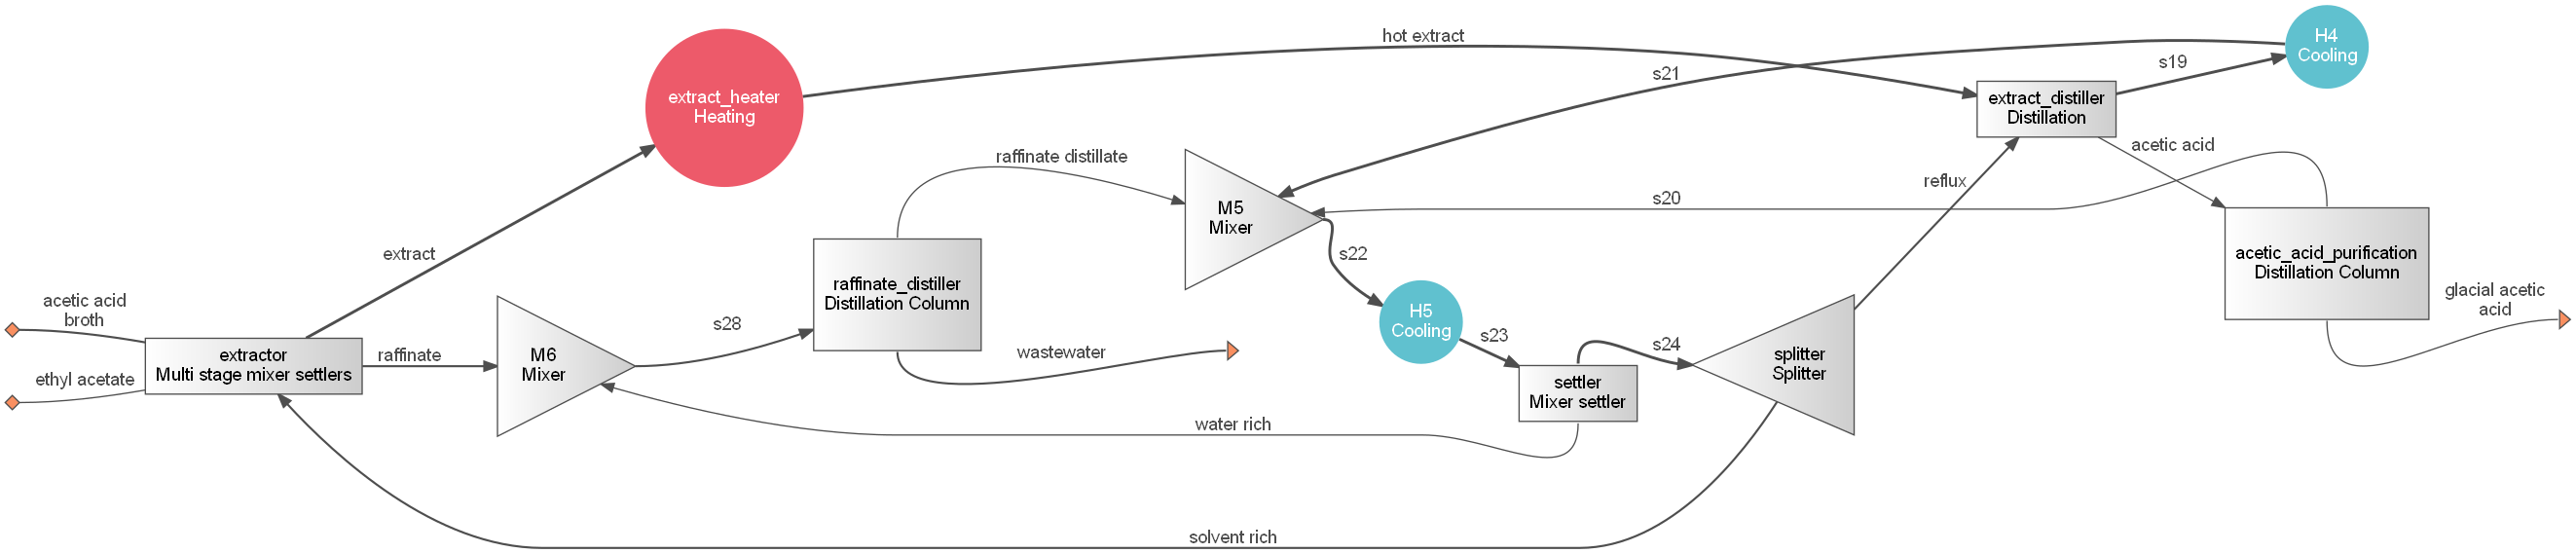

System: AAsep
Highest convergence error among components in recycle
streams {extract_heater-0, splitter-1, M5-0, settler-1} after 22 loops:
- flow rate   8.10e-05 kmol/hr (0.00038%)
- temperature 1.33e-06 K (3.9e-07%)
ins...
[0] acetic_acid_broth  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water       500
                    AceticAcid  16.7
[1] ethyl_acetate  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): EthylAcetate  0.139
outs...
[0] wastewater  
    phase: 'l', T: 372.15 K, P: 101325 Pa
    flow (kmol/hr): Water         500
                    AceticAcid    1.93
                    EthylAcetate  0.0841
[1] glacial_acetic_acid  
    phase: 'l', T: 389.88 K, P: 101325 Pa
    flow (kmol/hr): Water         0.000157
                    AceticAcid    14.7
                    EthylAcetate  0.0543


In [11]:
bst.settings.set_thermo(['Water', 'AceticAcid', 'EthylAcetate'], Phi=bst.SRKFugacityCoefficients)
bst.settings.mixture.include_excess_energies = True
reflux = bst.Stream('reflux')

# Amount of ethyl-acetate to fermentation broth
solvent_feed_ratio = 1.5

# Fermentation broth with dilute acetic acid
acetic_acid_broth = bst.Stream(ID='acetic_acid_broth', AceticAcid=1000, Water=9000, units='kg/hr')

# Solvent 
ethyl_acetate = bst.Stream(ID='ethyl_acetate',  EthylAcetate=1)

# Products
glacial_acetic_acid = bst.Stream(ID='glacial_acetic_acid')
wastewater = bst.Stream(ID='wastewater')

# Recycles
solvent_recycle = bst.Stream('solvent_rich')
water_rich = bst.Stream('water_rich')
distillate = bst.Stream('raffinate_distillate')

# System and unit operations
with bst.System('AAsep') as sys:
    extractor = bst.MultiStageMixerSettlers(
        'extractor', 
        ins=(acetic_acid_broth, ethyl_acetate, solvent_recycle), 
        outs=('extract', 'raffinate'),
        top_chemical='EthylAcetate',
        feed_stages=(0, -1, -1),
        N_stages=12,
        use_cache=True,
    )

    @extractor.add_specification(run=True)
    def adjust_fresh_solvent_flow_rate():
        broth = acetic_acid_broth.F_mass
        EtAc_recycle = solvent_recycle.imass['EthylAcetate']
        other_recycle = solvent_recycle.F_mass - EtAc_recycle
        ethyl_acetate.imass['EthylAcetate'] = max(
            0, (broth + other_recycle) * solvent_feed_ratio - EtAc_recycle
        )

    HX = bst.HXutility(
        'extract_heater',
        ins=(extractor.extract),
        outs=('hot_extract'),
        rigorous=True,
        V=0,
    )
    ED = bst.MESHDistillation(
        'extract_distiller',
        ins=(HX-0, reflux),
        outs=('', 'acetic_acid'),
        feed_stages=[feed_stage-3, 1], 
        N_stages=N_stages,
        reflux=0,
        boilup=boilup,
        LHK=('Water', 'AceticAcid'),
    )
    ED2 = bst.ShortcutColumn(
        'acetic_acid_purification',
        ins=ED-1,
        outs=('', glacial_acetic_acid),
        LHK=('EthylAcetate', 'AceticAcid'),
        Lr=0.999,
        Hr=0.999,
        k=1.4,
        partial_condenser=False
    )
    ED.check_LHK = ED2.check_LHK = False
    HX = bst.HXutility(ins=ED-0, V=0, rigorous=True)
    mixer = bst.Mixer(
        ins=(HX-0, ED2-0, distillate)
    )
    HX = bst.HXutility(ins=mixer-0, T=310)
    settler = bst.MixerSettler(
        'settler',
        ins=HX-0, 
        outs=('', water_rich),
        top_chemical='EthylAcetate',
    )
    splitter = bst.Splitter(
        'splitter',
        ins=settler-0,
        outs=(reflux, solvent_recycle),
        split=split,
    )
    mixer = bst.Mixer(ins=[extractor.raffinate, water_rich])
    RD = bst.ShortcutColumn(
        'raffinate_distiller',
        LHK=('EthylAcetate', 'Water'),
        ins=mixer-0,
        outs=[distillate, wastewater],
        partial_condenser=False,
        Lr=0.99,
        Hr=0.99,
        k=1.5,
    )
sys.set_tolerance(rmol=1e-6, mol=1e-3, subsystems=True)
sys.flatten()
sys.simulate()
sys.diagram(format='png')
sys.show()

In [12]:
sys.operating_hours = 330 * 24
print('CAPEX', round(sys.installed_equipment_cost / 1e6, 3), 'MMUSD')
print('OPEX', round(sys.material_cost + sys.utility_cost / 1e6, 4), 'MMUSD/yr')

CAPEX 1.811 MMUSD
OPEX 0.984 MMUSD/yr
